 # [Module 2.2] 타겟 인코딩 데이터를 사용하여 AutoGluon 훈련 및 추론

이 노트북은 기본으로 AutoGluon과 동일한 작업을 합니다.
- 데이터 로딩
- AutoGluon 데이터 타입으로 변경
- AutoGluon 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

In [1]:
import pandas as pd

In [2]:
%store -r te_auto_train_file
%store -r te_auto_test_file

In [3]:
te_auto_train_file

'preproc_data/fe/te_auto/train.csv'

## 데이터 로딩

In [4]:
train_pd = pd.read_csv(te_auto_train_file)
test_pd = pd.read_csv(te_auto_test_file)

In [5]:
print("auto_train_file: ", train_pd.shape)
print("auto_train_file: ", test_pd.shape)

auto_train_file:  (53740, 19)
auto_train_file:  (13436, 19)


In [6]:
from IPython.display import display as dp
dp(train_pd.head(2))
dp(test_pd.head(2))

,classes,price,freight_value,product_weight_g,product_volume,order_weekday,order_day,order_month,te_product_id_mean_smoothed,te_product_category_name_english_mean_smoothed,te_seller_state_mean_smoothed,te_seller_city_mean_smoothed,te_seller_zip_code_prefix_mean_smoothed,te_customer_seller_city_mean_smoothed,te_customer_seller_state_mean_smoothed,te_customer_seller_zip_code_prefix_mean_smoothed,te_customer_city_mean_smoothed,te_customer_state_mean_smoothed,te_customer_zip_code_prefix_mean_smoothed
0,3,29.99,10.96,9000.0,2640.0,1,4,10,2.178684,2.622326,2.083211,1.808092,1.739918,2.184425,1.616774,2.214833,2.285411,1.779978,2.194247
1,2,23.90,26.82,1500.0,14625.0,1,4,10,2.183505,2.251594,2.088750,2.223340,2.191372,2.192036,3.135032,2.158596,2.196679,3.206532,2.140138


,classes,price,freight_value,product_weight_g,product_volume,order_weekday,order_day,order_month,te_product_id_mean_smoothed,te_product_category_name_english_mean_smoothed,te_seller_state_mean_smoothed,te_seller_city_mean_smoothed,te_seller_zip_code_prefix_mean_smoothed,te_customer_seller_city_mean_smoothed,te_customer_seller_state_mean_smoothed,te_customer_seller_zip_code_prefix_mean_smoothed,te_customer_city_mean_smoothed,te_customer_state_mean_smoothed,te_customer_zip_code_prefix_mean_smoothed
0,3,105.00,23.89,1000.0,7632.0,1,19,6,2.375643,2.226556,2.160354,2.128877,2.669442,2.163996,2.191651,2.165779,2.584761,2.659808,2.174072
1,0,99.97,15.80,650.0,9600.0,1,19,6,2.165296,2.032511,2.321770,1.964664,2.169721,2.165855,2.252129,2.182558,1.635057,1.795784,2.154418


#### 에러 발생시 아래 처럼 수행
1. pip install autogluon
2. pip install --upgrade mxnet
3. from autogluon.tabular import TabularPrediction -> from autogluon import TabularPrediction 수정(실제로는 deprecate 된 api임)

In [7]:
# ! pip install autogluon
# # ! pip install --upgrade mxnet
# ! pip install mxnet==1.6.0

In [8]:
import autogluon.core as ag
from autogluon.tabular import TabularPrediction as task
# from autogluon import TabularPrediction as task

## 오토글루온 데이터 타입으로 변경

In [9]:
train_data = task.Dataset(file_path=te_auto_train_file)
subsample_size = train_data.shape[0]
# subsample_size = 10000  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head(2))

       classes   price  freight_value  product_weight_g  product_volume  \
588          2   59.99          18.00             525.0          9280.0   
45386        3  120.00          18.72            1300.0          4864.0   

       order_weekday  order_day  order_month  te_product_id_mean_smoothed  \
588                0         30            1                     2.202766   
45386              4         27            4                     2.186062   

       te_product_category_name_english_mean_smoothed  \
588                                          2.204250   
45386                                        2.136287   

       te_seller_state_mean_smoothed  te_seller_city_mean_smoothed  \
588                         2.057660                      1.590842   
45386                       2.116175                      1.849842   

       te_seller_zip_code_prefix_mean_smoothed  \
588                                   1.755359   
45386                                 2.154521   

       t

In [10]:
label_column = 'classes'
print("Summary of class variable: \n", train_data[label_column].describe())

Summary of class variable: 
 count    53740.000000
mean         2.178675
std          1.152687
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: classes, dtype: float64


## 오토글루운으로 훈련

In [11]:
%%time
dir = 'advFE-agModels-predictClass'  # specifies folder where to store trained models
time_limits = 7200 # seconds
# presets = 'best_quality'
presets = 'medium_quality_faster_train'

predictor = task.fit(train_data=train_data, label=label_column, 
                     output_directory=dir,
                     time_limits=time_limits,
                     presets=presets)



Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to agModels-predictClass/
AutoGluon Version:  0.0.15b20201117
Train Data Rows:    53740
Train Data Columns: 18
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [2, 3, 1, 0, 4]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    69613.26 MB
	Train Data (Original)  Memory Usage: 7.74 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFea

CPU times: user 16min 38s, sys: 39.3 s, total: 17min 18s
Wall time: 7min 36s


## 테스트 데이터 로딩

In [12]:
test_data = task.Dataset(file_path=te_auto_test_file)
y_test = test_data[label_column]  # values to predict
test_data_nolab = test_data.drop(labels=[label_column],axis=1)  # delete label column to prove we're not cheating
print(test_data_nolab.head(2))

Loaded data from: preproc_data/fe/te_auto/test.csv | Columns = 19 / 19 | Rows = 13436 -> 13436


    price  freight_value  product_weight_g  product_volume  order_weekday  \
0  105.00          23.89            1000.0          7632.0              1   
1   99.97          15.80             650.0          9600.0              1   

   order_day  order_month  te_product_id_mean_smoothed  \
0         19            6                     2.375643   
1         19            6                     2.165296   

   te_product_category_name_english_mean_smoothed  \
0                                        2.226556   
1                                        2.032511   

   te_seller_state_mean_smoothed  te_seller_city_mean_smoothed  \
0                       2.160354                      2.128877   
1                       2.321770                      1.964664   

   te_seller_zip_code_prefix_mean_smoothed  \
0                                 2.669442   
1                                 2.169721   

   te_customer_seller_city_mean_smoothed  \
0                               2.163996   
1      

## 모델 예측

In [14]:
predictor = task.load(dir)  # unnecessary, just demonstrates how to load previously-trained predictor from file

prediction = predictor.predict(test_data_nolab)
print("Predictions:  ", prediction)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.45229234891336706
Evaluations on test data:
{
    "accuracy": 0.45229234891336706,
    "accuracy_score": 0.45229234891336706,
    "balanced_accuracy_score": 0.43476185401753586,
    "matthews_corrcoef": 0.2748640692201641
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.6150137741046832,
        "recall": 0.5237536656891496,
        "f1-score": 0.5657269559708584,
        "support": 1705
    },
    "1": {
        "precision": 0.5473064735174287,
        "recall": 0.290485343584815,
        "f1-score": 0.3795322555328834,
        "support": 4162
    },
    "2": {
        "precision": 0.4541180567647571,
        "recall": 0.5750826901874311,
        "f1-score": 0.5074917299085425,
        "support": 4535
    },
    "3": {
        "precision": 0.3551488833746898,
        "recall": 0.5281365313653137,
        "f1-score": 0.42470326409495546,
        "support": 2168
    },
    "4": {
        "precision": 0.274752475247524

Predictions:   [2 2 2 ... 2 0 0]


## 리더 보드 생성

In [15]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoostClassifier,0.453781,0.4612,0.084197,0.028900,5.546677,0.084197,0.028900,5.546677,0,True,11
1,weighted_ensemble_k0_l1,0.452292,0.4780,9.818993,1.566221,313.315341,0.020217,0.000897,0.678365,1,True,13
2,NeuralNetClassifier,0.452069,0.4516,0.389674,0.046186,107.099226,0.389674,0.046186,107.099226,0,True,1
3,LightGBMClassifierCustom,0.451697,0.4688,0.032582,0.014399,3.254341,0.032582,0.014399,3.254341,0,True,12
4,LightGBMClassifier,0.451176,0.4664,0.014410,0.004645,0.685000,0.014410,0.004645,0.685000,0,True,8
5,CatboostClassifier,0.450134,0.4584,0.030249,0.019569,7.924009,0.030249,0.019569,7.924009,0,True,10
6,LightGBMClassifierXT,0.449241,0.4580,0.029478,0.006990,1.371351,0.029478,0.006990,1.371351,0,True,9
7,RandomForestClassifierEntr,0.445445,0.4552,1.417050,0.308311,190.815331,1.417050,0.308311,190.815331,0,True,5
8,RandomForestClassifierGini,0.442394,0.4608,1.540463,0.314575,55.686991,1.540463,0.314575,55.686991,0,True,4
9,ExtraTreesClassifierGini,0.434653,0.4524,3.109029,0.420263,19.544911,3.109029,0.420263,19.544911,0,True,6


## 모델 평가

In [16]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.45%
f1_score: 0.43%


[[ 893  450  342   18    2]
 [ 309 1209 1849  728   67]
 [ 183  351 2608 1054  339]
 [  50  155  640 1145  178]
 [  17   44  304  279  222]]


<Figure size 432x288 with 0 Axes>

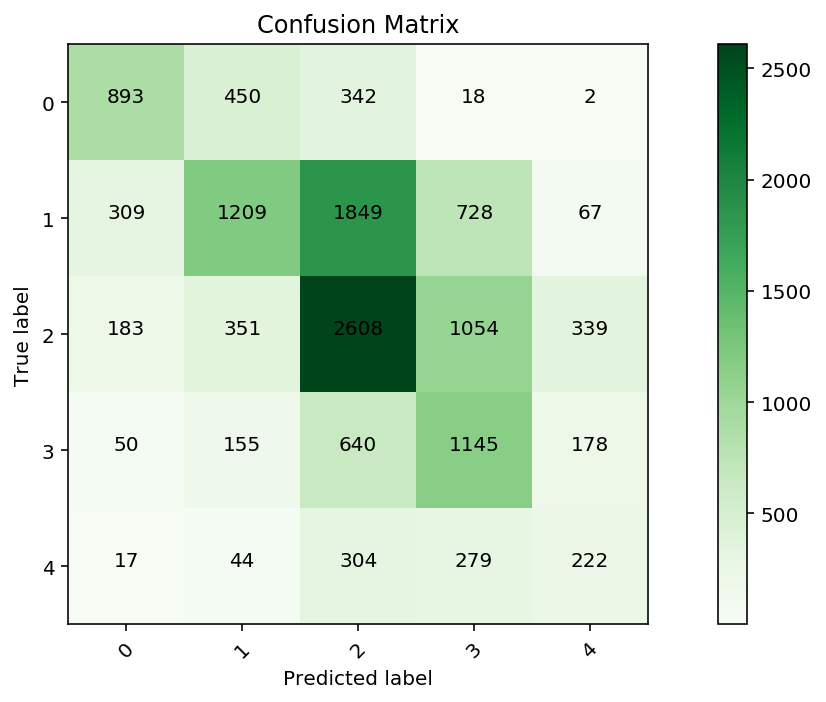

In [17]:
from p_utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

Computing raw permutation importance for 18 features on weighted_ensemble_k0_l1 ...
	106.42s	= Expected runtime
	80.42s	= Actual runtime


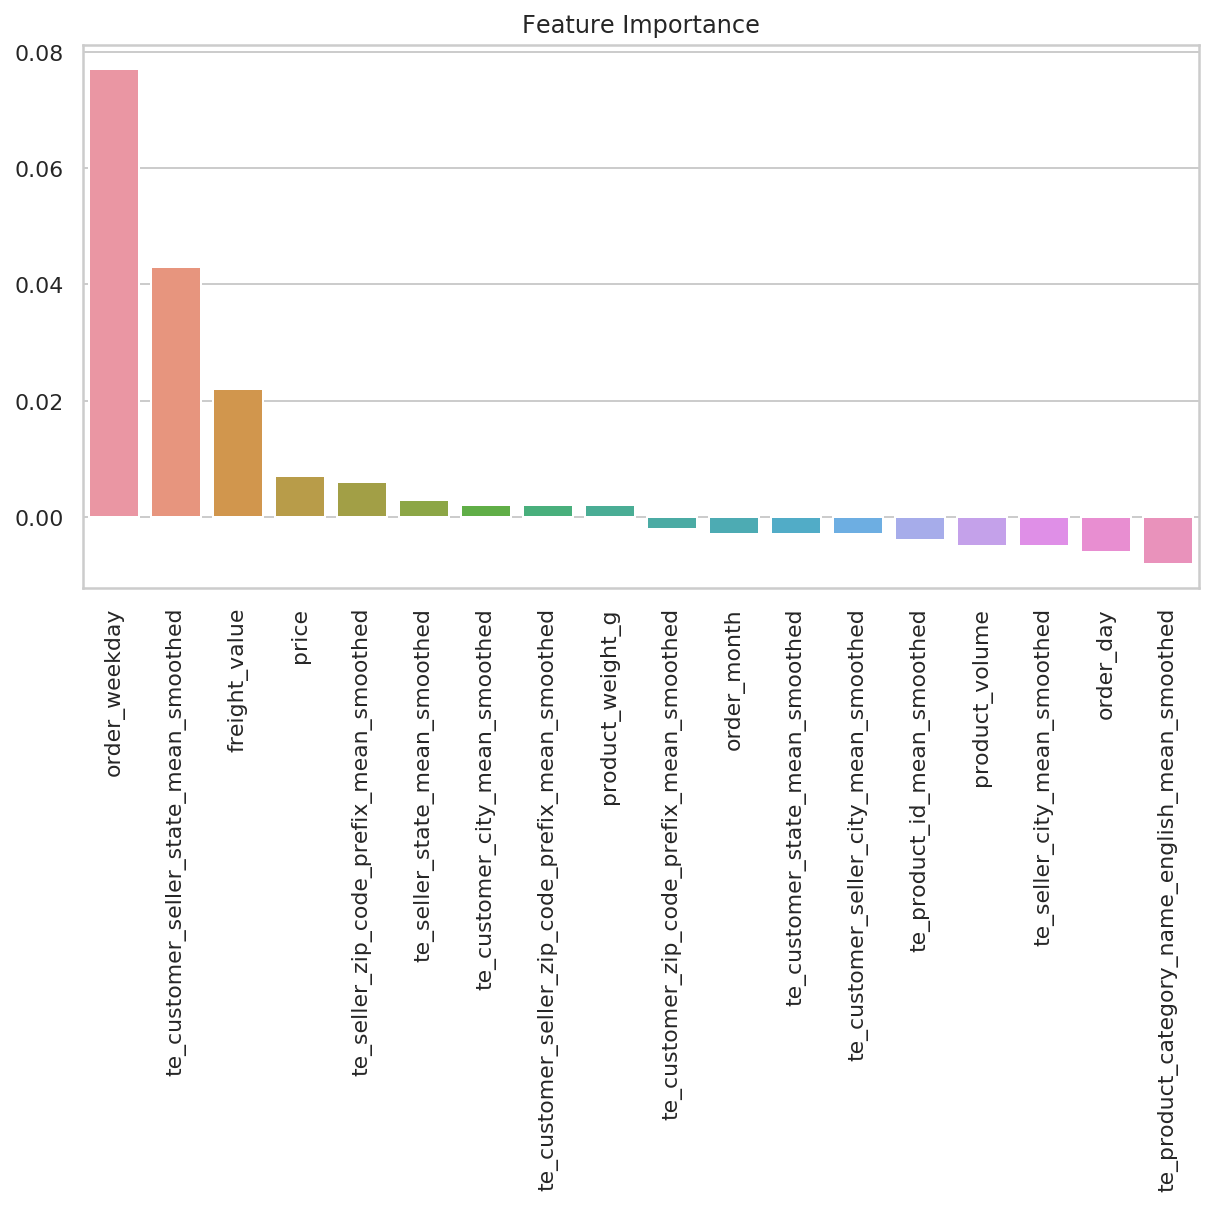

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance = predictor.feature_importance(test_data)

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_importance.index, y = fea_importance.values)
# plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()